In [1]:

import pandas as pd 
import numpy as np

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split


In [2]:
#model :P 

class RainNet(nn.Module):
    def __init__(self,features):
        super().__init__()
        self.model_MLP = nn.Sequential(
            nn.Linear(features, 32), nn.ReLU(),
            nn.BatchNorm1d(32), nn.Dropout(0.3),
            nn.Linear(32, 16), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(16, 1) 
        )
    def forward(self,x):
        return self.model_MLP(x)


In [6]:
# loading data :D  (not PCA)
df = pd.read_csv('../official_weather_data/kma_train.csv')

features = torch.tensor(df.drop(columns=['id','rainfall']).values.astype(np.float32))
labels = torch.tensor(df['rainfall'].values.astype(np.float32).reshape(-1,1))
dataset= TensorDataset(features,labels)

train_set, val_set = random_split(
    dataset,
    [int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))],
    generator=torch.Generator().manual_seed(42)
)

train_loader=DataLoader(train_set, batch_size=32,shuffle=True)
val_loader=DataLoader(val_set,batch_size=32,shuffle=False)


In [12]:
#Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RainNet(features.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
n_epochs=500


train_losses, val_losses = [],[]


for epoch in tqdm(range(1,n_epochs+1)):
    #train
    model.train()
    sum_loss=0.0
    for xb,yb in train_loader:

        xb,yb =  xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss=criterion(model(xb),yb)
        loss.backward()
        optimizer.step()
        sum_loss +=loss.item()*xb.size(0)

    epoch_train = sum_loss / len(train_loader.dataset)
    train_losses.append(epoch_train)

    # validation
    model.eval()
    sum_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            loss = criterion(model(xb), yb)
            sum_loss += loss.item() * xb.size(0)
    epoch_val = sum_loss / len(val_loader.dataset)
    val_losses.append(epoch_val)

    #print(f"Epoch {epoch:02d} | train {epoch_train:.4f} | val {epoch_val:.4f}")


100%|██████████| 500/500 [01:33<00:00,  5.32it/s]


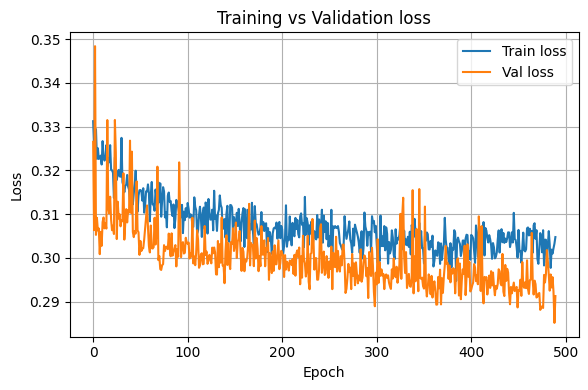

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6,4))
plt.plot(train_losses[10:], label="Train loss")
plt.plot(val_losses[10:],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model, "rainnet_full_model_2.pt")

In [16]:
#test
from sklearn.metrics import accuracy_score

df = pd.read_csv("../official_weather_data/kma_test.csv")

X_test = torch.tensor(df.drop(columns=["id", "rainfall"]).values, dtype=torch.float32)
y_test = torch.tensor(df["rainfall"].values, dtype=torch.float32).reshape(-1, 1)

X_test = X_test.to(device)
y_test = y_test.to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

acc = accuracy_score(y_test.cpu().numpy(), preds.cpu().numpy())
print(f"precision : {acc*100:.2f}%")


precision : 89.68%


In [18]:
from sklearn.metrics import f1_score, roc_auc_score

def evaluate_metrics(y_true, probs, preds):
    y_true = y_true.cpu().numpy()
    probs = probs.cpu().numpy()
    preds = preds.cpu().numpy()

    f1 = f1_score(y_true, preds)
    auc = roc_auc_score(y_true, probs)

    print(f"F1-score : {f1:.4f}")
    print(f"rOC AUC  : {auc:.4f}")

evaluate_metrics(y_test, probs, preds)

F1-score : 0.7838
rOC AUC  : 0.9500


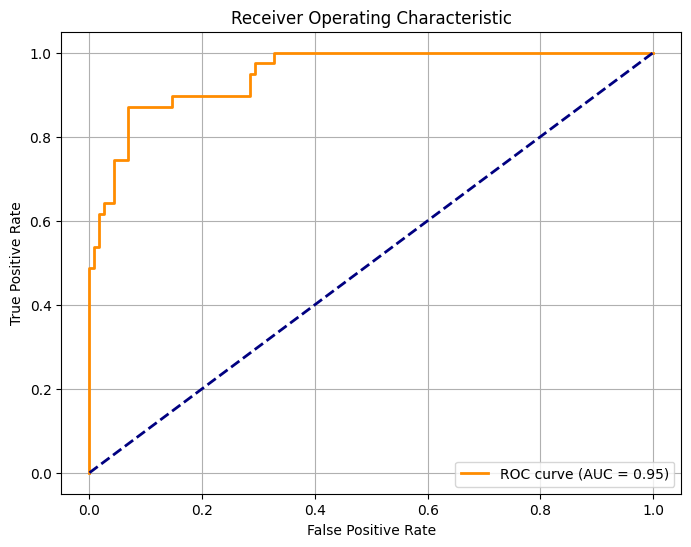

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, probs):
    y_true = y_true.cpu().numpy()
    probs = probs.cpu().numpy()
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="darkorange", lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
plot_roc_curve(y_test, probs)
